# TODO
-  WeightedRandomSampler
- weighted binary cross entropy loss
- transformations
- https://arxiv.org/pdf/1711.05225.pdf
- https://github.com/zoogzog/chexnet
- Faster R-CNN 


In [1]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pydicom
from pathlib import Path
import skimage.transform
from collections import namedtuple, defaultdict
from matplotlib.patches import Rectangle

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def file2id(file_name):
    p = Path(file_name)
    return p.stem
file2id('train_png128/019e035e-2f82-4c66-a198-57422a27925f.png')

'019e035e-2f82-4c66-a198-57422a27925f'

In [3]:
PATH = Path('/home/paperspace/data/pneumonia/')

In [4]:
file2target = pd.read_csv(PATH/'file2target.csv')
train_n = file2target.shape[0]
train_n

25684

In [5]:
all_ids = list(set(map(file2id, file2target['file'])))
len(all_ids)

25684

In [6]:
val_idxs = get_cv_idxs(train_n)
val_idxs.shape

(5136,)

In [7]:
bs  = 256
arch = resnet50
sz=128

In [8]:
m = arch(True)
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [9]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train_png512', PATH/'file2target.csv',
                                   val_idxs=val_idxs, bs=bs, tfms=tfms, test_name='test_png512')

In [31]:
augdl = data.aug_dl
augdl

In [27]:
tfms[0].tfms

21
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


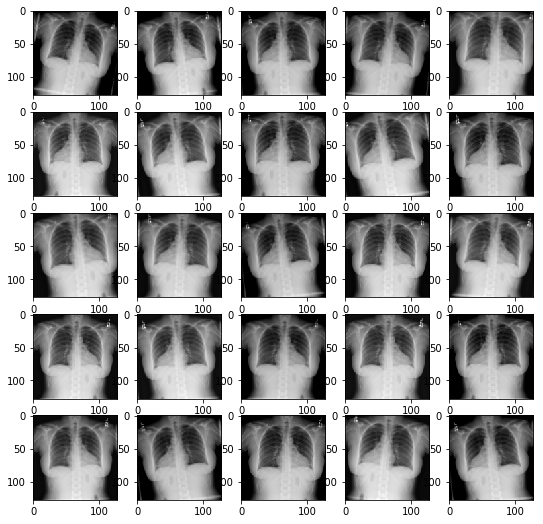

In [33]:
idx=0
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(augdl))
    print(y[idx])
    ima=data.val_ds.denorm(to_np(x))[idx]
    #b = bb_hw(to_np(y[idx]))
    
    ax.imshow(ima)
    #draw_rect(ax, b)

In [10]:
learn = ConvLearner.from_model_data(m, data)

In [12]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 512, 512]),
                           ('output_shape', [-1, 64, 256, 256]),
                           ('trainable', True),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 256, 256]),
                           ('output_shape', [-1, 64, 256, 256]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 256, 256]),
                           ('output_shape', [-1, 64, 256, 256]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 256, 256]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 128,

 89%|████████▉ | 575/643 [10:25<01:14,  1.09s/it, loss=1.16] 

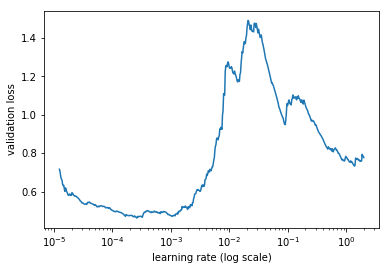

In [101]:
learn.lr_find()
learn.sched.plot()

In [13]:
learn.freeze_to(-4)

In [17]:
lr = 1e-4

In [14]:
learn.fit(1e-4, 5)

epoch      trn_loss   val_loss   accuracy                    
    0      0.421171   0.421518   0.804517  
    1      0.408321   0.396523   0.818146                    
    2      0.399743   0.428267   0.792251                    
    3      0.402142   0.416193   0.803738                    
    4      0.411612   0.394493   0.819315                    



[array([0.39449]), 0.8193146417445483]

In [20]:
learn.unfreeze()

In [21]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.379636   0.398937   0.814252  
    1      0.394529   0.391319   0.817562                    
    2      0.367546   0.386834   0.822819                    
    3      0.370736   0.379573   0.827492                    
    4      0.385002   0.37992    0.82535                     
    5      0.35707    0.370238   0.829245                    
    6      0.355084   0.37148    0.834696                    



[array([0.37148]), 0.834696261682243]

In [22]:
learn.save('learn512_835_forCAM')

In [11]:
#learn.load('learn84_forCAM')
learn.load('learn512_835_forCAM')

In [23]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0) #mean out of 5 transforms
accuracy_np(probs, y)

0.8407320872274143

In [24]:
preds = np.argmax(probs, axis=1)
preds.sum()

744

[[3802  228]
 [ 590  516]]


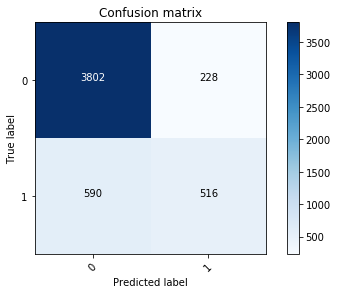

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

In [12]:
BBox = namedtuple('BBox', 'x1 y1 x2 y2')

In [13]:
def area(b):
    if b.x1 >= b.x2 or b.y1 >= b.y2: return 0
    return (b.x2-b.x1)*(b.y2 - b.y1)
area(BBox(0,0,100,100))

10000

In [14]:
def IoU(b1, b2):
    inter = BBox(max(b1.x1,b2.x1), max(b1.y1,b2.y1), min(b1.x2,b2.x2), min(b1.y2,b2.y2))
    union = area(b1)+area(b2)-area(inter)
    return area(inter)/union
IoU(BBox(0,10,30,40), BBox(10,10,40,40))

0.5

In [15]:
def score_tre(tresh, preds, actuals):
    pred_hits = np.full(len(preds), False)
    act_hits = np.full(len(actuals), False)
    for pi in range(len(preds)):
        for ai in range(len(actuals)):
            if pred_hits[pi] or act_hits[ai]: continue
            b1,b2 = preds[pi], actuals[ai]
            if IoU(b1,b2) >= tresh: pred_hits[pi]=act_hits[ai]=True
    tp = np.sum(pred_hits == True)
    fp = np.sum(pred_hits == False)
    fn = np.sum(act_hits == False)
    #print(tp,fp,fn)
    return tp / (tp+fp+fn)
p = [BBox(0,10,30,40)]; a= [BBox(10,10,40,40),BBox(40,40,50,50)]
score_tre(.1, p,a)

0.5

In [16]:
def score(preds, actuals):
    ret =0
    for thr in np.linspace(0.4,0.75,8):
        ret+= score_tre(thr, preds,actuals)
    return ret/8
p = [BBox(0,10,30,40)]; a= [BBox(10,10,40,40),BBox(40,40,50,50)]
score(p,[])     

0.0


bbox_df = pd.read_csv(PATH/'image_bbox_full.csv')
bbox_map = defaultdict(list)
for index, row in bbox_df.iterrows():
    if not pd.isna(row['x']):
        bbox = BBox(row['x'], row['y'], row['x']+row['width'], row['y']+row['height'])
        bbox_map[row['patientId']].append(bbox)
import pickle
file = PATH/'bbox_mapl.pkl'
with file.open('wb') as f:
    pickle.dump(bbox_map, f)

In [17]:
file = PATH/'bbox_mapl.pkl'
with file.open('rb') as f:
    bbox_map = pickle.load(f)

In [18]:
len(bbox_map)

5660

In [19]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

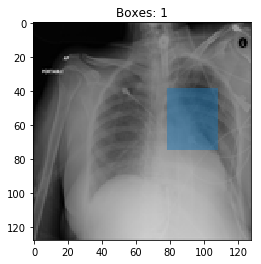

In [20]:

def plot_info(id, ax=None):
    if ax is None: _,ax = plt.subplots(1,1)
    boxes = bbox_map[id]
    path = PATH/f'train_png128/{id}.png'
    ax.imshow(PIL.Image.open(path), cmap='bone')
    ax.set_title(f'Boxes: {len(boxes)}')
    for bi in boxes:
        ax.add_patch(Rectangle(xy=(bi.x1/8, bi.y1/8),
                                width=(bi.x2-bi.x1)/8,
                                height=(bi.y2-bi.y1)/8, 
                                 alpha = 0.5,
                                fill=True))
plot_info('816cef8f-cbf7-43c7-8386-609bd95c78e6')

In [21]:
def plot(imgs , rows, cols):
    fig, m_axs = plt.subplots(rows, cols, figsize = (20, 10))
    for img, ax in zip(imgs, m_axs.flatten()):
        ax.imshow(img, cmap='bone')


In [22]:
def plot_cmap(dx, f2, ax):
    largest = np.unravel_index(np.argmax(f2),f2.shape)
    x, y = largest[1]*32, largest[0]*32
    ax.imshow(dx, cmap='bone')
    scaled = skimage.transform.resize(f2, (128,128), mode='reflect', anti_aliasing=True)
    ax.imshow(scaled, alpha=0.5, cmap='hot')
    ax.add_patch(Rectangle(xy=(x,y),width=32,height=32,alpha=0.5,fill=True))
    

In [23]:
it = iter(data.val_dl)
x,y = next(it)
x,y = x[None,1], y[None,1]
sfs = [SaveFeatures(o) for o in [m[-9],m[-8],m[-7], m[-6], m[-5], m[-4]]]
py =m(Variable(x.cuda()))
[o.features.size() for o in sfs]

[torch.Size([1, 64, 128, 128]),
 torch.Size([1, 64, 128, 128]),
 torch.Size([1, 128, 64, 64]),
 torch.Size([1, 256, 32, 32]),
 torch.Size([1, 512, 16, 16]),
 torch.Size([1, 2, 16, 16])]

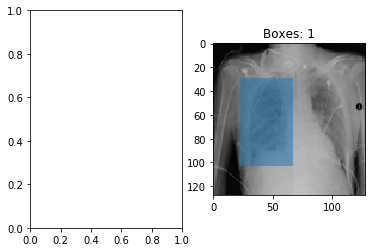

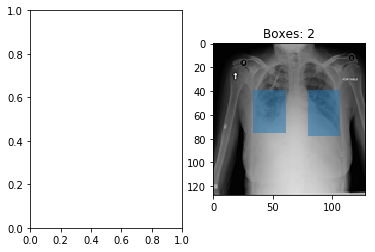

In [30]:
startId = 0
it = iter(data.val_dl)
bs=4
data.val_dl.batch_sampler.batch_size=bs
for bi in range(10):
    x,y = next(it)
    file_names = data.val_ds.fnames[startId:startId+bs]
    vx = Variable(x.cuda(), requires_grad=True)
    sfs = SaveFeatures(m[-4])
    py =m(Variable(x.cuda()))
    probs = np.exp(to_np(py))
    preds = np.argmax(probs, axis=1)
    preds
    for i in range(bs):
        if preds[i]:
            f2 = to_np(sfs.features[i][1])
            f2-=f2.min()
            f2/=f2.max()
            dx = data.val_ds.denorm(x[i])[0]
            _,ax = plt.subplots(1,2)
            #plot_cmap(dx, f2,ax[0])
            plot_info(file2id(file_names[i]), ax[1])
    startId = startId + bs
    sfs.remove()

In [32]:
test_preds,_ = learn.TTA(is_test=True)

In [41]:
probs = np.mean(np.exp(test_preds),0)
probs

array([[0.93727, 0.06273],
       [0.98178, 0.01822],
       [0.90353, 0.09647],
       ...,
       [0.3393 , 0.6607 ],
       [0.75288, 0.24712],
       [0.51688, 0.48312]], dtype=float32)

In [42]:
preds = np.argmax(probs, axis=1)
preds

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 

In [46]:
test_id = list(map(file2id, data.test_ds.fnames))
test2pred = zip(test_id, preds)
outs = [(id, '.5 391 363 220 334' if pr else '') for id, pr in test2pred]
out_df = pd.DataFrame(outs, columns = ['patientId', 'PredictionString'])
out_df.set_index('patientId', inplace=True)
out_df.to_csv(PATH/'subm_fixed.csv')

In [43]:
pred_box = BBox(381,373,381+218,373+318)
tot_score =0
for id in all_ids:
    tot_score += score([pred_box], bbox_map[id])
tot_score /len(all_ids)

0.0007519272698956549

In [58]:
id2pred = list(zip(list(map(file2id, data.val_ds.fnames)), preds))

In [59]:
id2pred

[('0100515c-5204-4f31-98e0-f35e4b00004a', 0),
 ('019e035e-2f82-4c66-a198-57422a27925f', 0),
 ('01a4059c-22f7-4f51-8a27-50aff0b3aeb3', 0),
 ('01aad2a6-3b93-45e3-bf37-2d73348cb6fc', 0),
 ('01adfd2f-7bc7-4cef-ab68-a0992752b620', 0),
 ('01cad8d0-45cd-4603-b099-94055d322310', 1),
 ('01cd2ba5-2baf-44b2-bf15-ee57e1ea4599', 0),
 ('01e16ddb-682d-4901-b56d-8686c4f9f976', 0),
 ('01e800d4-4d8d-4ef5-a40a-f37b923bb7ad', 0),
 ('01ef449e-d493-4db2-9162-d83c69f90f40', 0),
 ('02051597-8a40-4586-88e1-8e62e421981f', 0),
 ('02285fa4-35b7-4af6-b88f-3cac45a7f5c8', 0),
 ('02c2331d-b3fa-4d55-bf86-f0efbd589c86', 1),
 ('035789b1-3736-405d-9910-f8f23c62ae9f', 0),
 ('03c149d1-e420-40bf-8d60-f98d0fff1d48', 0),
 ('03d00867-fe6d-47b5-9a14-3f03f736e69a', 0),
 ('03da08b4-9f24-4822-8b2b-4abf27e3c9a8', 0),
 ('049d7317-5a8b-4fc4-b81f-159fe6b45a92', 0),
 ('04d59a79-e659-49ca-8790-511f89ac3e1b', 0),
 ('051e6e97-fda7-4b5c-8d5f-084bf3607d22', 0),
 ('056d6cc6-fb4a-48a5-808b-b775d29a438a', 0),
 ('056f6beb-c3c8-4ee3-8db5-d1b50aa

In [60]:
toscore=0;count=0
for id,pred in id2pred:
    if(pred or bbox_map[id]):
        score += score([pred_box], bbox_map[id])
        count+=1
print(score/count)

TypeError: 'int' object is not callable